# Node embed for character in word morphology

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("../")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pickle
import gzip
import json
from pathlib import Path

In [3]:
from torchtext.vocab import Vectors
from matplotlib_venn import venn3

In [4]:
from CwnGraph import CwnBase

In [5]:
cwn = CwnBase()
cwn_lemmas = (x["lemma"] for x in cwn.V.values() if x["node_type"] == "lemma")
cwn_lemmas = list(filter(lambda x: 0 < len(x) <= 2, cwn_lemmas))

In [6]:
with gzip.open("../resources/deeplexicon_export_181209005320.json.gz", "rb") as fin:
    deeplex = json.load(fin)

In [7]:
dl_lemma_iter = (x["lu"] for x in deeplex)
dl_lemma = filter(lambda x: isinstance(x, str) and 0 < len(x) <= 2, dl_lemma_iter)
dl_lemma = list(set(dl_lemma))
dl_lemma.sort(key=lambda x: (len(x), x))

In [8]:
zhft = Vectors(name='wiki.zh.vec', cache='../resources/fasttext/')

In [9]:
with open("../resources/as_wordFreq.pickle", "rb") as fin:
    wfreq = pickle.load(fin)

In [10]:
OOV_wfreq = [x for x in cwn_lemmas if x not in wfreq]
OOV_fasttext = [x for x in cwn_lemmas if x not in zhft.stoi]

In [11]:
outdir = Path("../data/preproc_embed/")
outdir.mkdir(parents=True, exist_ok=True)
with open(outdir / "oov_wfreq.txt", "w", encoding="UTF-8") as fout:
    fout.write("\n".join(sorted(OOV_wfreq)))
with open(outdir / "oov_fasttext.txt", "w", encoding="UTF-8") as fout:
    fout.write("\n".join(sorted(OOV_fasttext)))

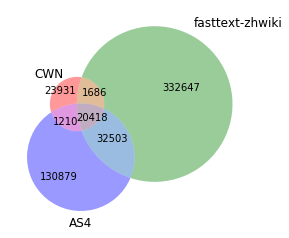

In [12]:
Abc = len(cwn_lemmas)
aBc = len(zhft.stoi)
abC = len(wfreq)
ABc = sum(1 for x in cwn_lemmas if x in zhft.stoi and x not in wfreq)
AbC = sum(1 for x in cwn_lemmas if x not in zhft.stoi and x in wfreq)
aBC = sum(1 for x in wfreq if x in zhft.stoi and x not in cwn_lemmas)
ABC = sum(1 for x in cwn_lemmas if x in zhft.stoi and x in wfreq)

venn3(subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC), set_labels = ('CWN', 'fasttext-zhwiki', 'AS4'))

In [13]:
print("CwnVectors Coverage: %.2f" % (ABC*100 / Abc,))

CwnVectors Coverage: 85.32


# Build CwnVectors

In [16]:
from MWE2019.cwn_vectors import CwnVectors

In [60]:
cwn_vec = CwnVectors()
if not cwn_vec:
    cwn_vec = CwnVectors(cwn_lemmas, zhft, wfreq)

load from cache:  E:\LangOn\MWE2019\data\cache_cwn_vectors\cwn_vectors.pkl


In [61]:
cwn_vec.dim

300

## Use gensim KeyedVectors to browse embeddings

In [62]:
from gensim.models import KeyedVectors

In [63]:
cwn_kv = KeyedVectors(cwn_vec.dim)
cwn_kv.add([cwn_vec.itos[i] for i in range(len(cwn_vec.itos))], cwn_vec.vectors)

In [64]:
cwn_kv.most_similar("情緒")

[('感覺', 0.9599748253822327),
 ('緊張', 0.9595120549201965),
 ('意識', 0.9588016271591187),
 ('心態', 0.9581484198570251),
 ('內心', 0.9581273794174194),
 ('恐懼', 0.9573620557785034),
 ('態度', 0.9571989178657532),
 ('憂悶', 0.9569420218467712),
 ('壓抑', 0.9563689827919006),
 ('陰沈', 0.9554392695426941)]

In [65]:
# 英國(a) - 倫敦(b) vs. 美國(x) - ??(y)
# a is to b as x is to y
# infer y = x - a + b
cwn_kv.most_similar(["美國", "倫敦"], ["英國"])

[('紐約', 0.9545028209686279),
 ('費城', 0.9343597888946533),
 ('賓州', 0.9328980445861816),
 ('加州', 0.9322183132171631),
 ('雪梨', 0.9272298216819763),
 ('頓', 0.9252379536628723),
 ('紐', 0.9215793609619141),
 ('奧', 0.92048579454422),
 ('諾', 0.9175513982772827),
 ('納', 0.9170501232147217)]

In [66]:
# 英國(a) - 倫敦(b) vs. 臺灣(x) - ??(y)
cwn_kv.most_similar(["臺灣", "倫敦"], ["英國"])

[('台灣', 0.9392246007919312),
 ('台北', 0.9351192712783813),
 ('臺北', 0.9322136640548706),
 ('宜蘭', 0.9305909276008606),
 ('台南', 0.930513858795166),
 ('高雄', 0.929668664932251),
 ('花蓮', 0.9285742044448853),
 ('臺南', 0.9285663962364197),
 ('台中', 0.923947811126709),
 ('新竹', 0.9239029884338379)]

In [67]:
# 記憶(a) - 忘記(b) vs. 知道(x) - ??(y)
cwn_kv.most_similar(["知道", "忘記"], ["記憶"])

[('明白', 0.9345259666442871),
 ('想到', 0.9332239627838135),
 ('真的', 0.926767110824585),
 ('怎的', 0.9248987436294556),
 ('看到', 0.9240320920944214),
 ('要是', 0.9240231513977051),
 ('可是', 0.9227776527404785),
 ('在乎', 0.9224362969398499),
 ('呢', 0.9222633242607117),
 ('怎地', 0.9219707250595093)]